# Download Repo and Setup Installation
Download the github repo containing the model, data, and weights

In [0]:
%cd

!git clone --quiet https://github.com/bwproud/mask_rcnn_recyclables.git

%cd ~/mask_rcnn_recyclables

!pip install -r requirements.txt
!python setup.py install

# Mount Directory
If you want to save your model or use images in your drive as input it's necessary to mount your directory


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Unzip Dataset
Unzip dataset that contains our images broken up by val/train/test and then by classes

In [0]:
%cd ~/mask_rcnn_recyclables
!rm -rf dataset

import os
from zipfile import ZipFile
from shutil import copy

os.makedirs('dataset')
os.chdir('dataset')

fileName = '../data.zip'
ds = ZipFile(fileName)
ds.extractall()
print('Extracted zip file ' + fileName)
print()

# Train model
If you want to train the model, run the cell below; you can customize the number of epochs, the number of layers to train, and the initial starting weights

In [0]:
%cd ~/mask_rcnn_recyclables

!python detect_recyclables.py train --dataset=dataset/ --weights=coco --epochs=30 --style=heads

# Load weights
Load your newly trained weights for use in inference.

If you didn't train and want to supply the weights, just put the path to your weights in custom_WEIGHTS_PATH. To test on our weights, go to https://drive.google.com/file/d/1AunkAymLdhg-dgJYU4jddjcjF0XMxzzJ/view and click "Add to my drive" or download it and add it to your drive manually. If you mounted your drive earlier then you should be able to retrieve our weights from your drive

In [0]:
%cd ~/mask_rcnn_recyclables

import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from importlib import reload
import detect_recyclables
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = detect_recyclables.RecycleConfig()
custom_DIR = os.path.join(ROOT_DIR, "dataset")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
val_dataset = detect_recyclables.RecycleDataset()
val_dataset.load_recycle(custom_DIR, "val")

# Must call before using the dataset
val_dataset.prepare()

print("Images: {}\nClasses: {}".format(len(val_dataset.image_ids), val_dataset.class_names))

# Load test dataset
test_dataset = detect_recyclables.RecycleDataset()
test_dataset.load_recycle(custom_DIR, "test")

# Must call before using the dataset
test_dataset.prepare()

print("Images: {}\nClasses: {}".format(len(test_dataset.image_ids), test_dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

def load_weights(model, weight_path):
  # Load weights
  print("Loading weights ", weight_path)
  model.load_weights(weight_path, by_name=True)

  reload(visualize)

# custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]
# TO RUN ON OUR WEIGHTS UNCOMMENT LINE BELOW AND COMMENT LINE ABOVE
# TO RUN ON YOUR OWN TRAINED WEIGHTS COMMENT LINE BELOW AND UNCOMMENT ABOVE
custom_WEIGHTS_PATH = '/content/gdrive/My Drive/custom_weights.h5'
load_weights(model, custom_WEIGHTS_PATH)

# Save weights
The cell below is used to save weights to your google drive so you can use them later

In [0]:
with open('/content/gdrive/My Drive/custom_weights.h5', 'wb') as f, open(custom_WEIGHTS_PATH, 'rb') as f1:
  f.write(f1.read())

# Test model
Use your trained model on the validation/test set and see your mean average precision

In [0]:
def runOnValSet(ds, name, mode):
  APs=[]
  for image_id in ds.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(ds, config, image_id, use_mini_mask=False)

    # Run object detection
    results = model.detect([image], verbose=1)

    # Display results
    r = results[0]
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                ds.class_names, r['scores'],
                                title="Predictions")
    APs.append(AP)
  print("%s (%s): mAP @ IoU=50: %s" % (name, mode, np.mean(APs)))
  return np.mean(APs)
runOnValSet(test_dataset, "custom_weights", "test")

# Test image from URL
Load an image from a URL and test it on your trained model

Processing 1 images
image                    shape: (280, 677, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[3 3 3 3 3 3]


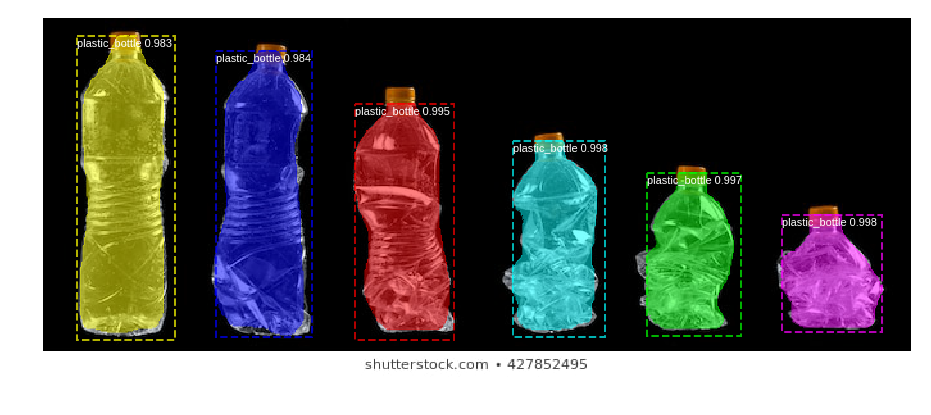

In [0]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image
  
image = load("https://image.shutterstock.com/image-photo/different-steps-compressing-plastic-bottle-260nw-427852495.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
print(r['class_ids'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_dataset.class_names, r['scores'])

# Detect in local photo or video
Use model to detect for recyclables in any photo or video. Video is broken into frames, with detection being run on each frame. ffmpeg is needed to stitch together pngs into the final video.

In [0]:
!apt-get install ffmpeg

In [0]:
import datetime
import cv2
def detectInImage(model, im_path):
    print("Running on {}".format(im_path))
    # Read image
    image = skimage.io.imread(im_path)
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    im = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                val_dataset.class_names, r['scores'], save=True)
    im.savefig('/content/gdrive/My Drive/test{}.png'.format(datetime.datetime.now()), bbox_inches='tight',
    pad_inches = 0.0, transparent=True)

def detectInVideo(model, video_path):
  # Video capture
  vcapture = cv2.VideoCapture(video_path)

  # Define codec and create video writer
  file_name = "/content/gdrive/My Drive/splash{}.avi".format(datetime.datetime.now())

  count = 0
  success = True
  colors = visualize.random_colors(len(val_dataset.class_names))
  while success:
      print("frame: ", count)
      # Read next image
      success, image = vcapture.read()
      if success:
          # OpenCV returns images as BGR, convert to RGB
          image = image[..., ::-1]
          # Detect objects
          r = model.detect([image], verbose=0)[0]

          im = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                val_dataset.class_names, r['scores'], colors=colors, save=True)
          im.savefig('/content/gdrive/My Drive/vid/test{}.png'.format(count), bbox_inches='tight',
    pad_inches = 0.0, transparent=True)
          count += 1

In [0]:
detectInImage(model, '/content/gdrive/My Drive/can.jpg')
detectInVideo(model, '/content/gdrive/My Drive/IMG_1776.MOV')
!ffmpeg -f image2 -r 24 -i '/content/gdrive/My Drive/vid/test%d.png' -vcodec mpeg4 -y '/content/gdrive/My Drive/vid/movie.mp4'
!rm -f /content/gdrive/'My Drive'/vid/*.png